# Stochastic coupled updraft/downdraft modelling

Thomas Schanzer  
February 2022

In this notebook, we demonstrate two stochastic/Monte Carlo approaches to modelling coupled updrafts and downdrafts.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import sys

import metpy.calc as mpcalc
from metpy.units import units, concatenate

from dparcel.thermo import (saturation_specific_humidity,
                            equivalent_potential_temperature)
sys.path.append('../convection_scheme')
from coupler import CoupledThermalGenerator
from stochastic_coupler import StochasticCoupledThermalGenerator

In [2]:
file = ('test_soundings/48698 WSSS Singapore Observations '
        'at 00Z 01 Dec 2021.txt')
sounding = pd.read_fwf(file, usecols=[0, 1, 2, 3], header=0)
sounding = sounding.to_numpy()
pressure_raw = sounding[:2:-1,0]
height_raw = sounding[:2:-1,1]
temperature_raw = sounding[:2:-1,2]
dewpoint_raw = sounding[:2:-1,3]

pressure = np.arange(pressure_raw[0], pressure_raw[-1], 5)*units.mbar
height = interp1d(pressure_raw, height_raw)(pressure)*units.meter
height -= height[-1]
temperature = interp1d(pressure_raw, temperature_raw)(pressure)*units.celsius
dewpoint = interp1d(pressure_raw, dewpoint_raw)(pressure)*units.celsius
specific_humidity = mpcalc.specific_humidity_from_dewpoint(pressure, dewpoint)
generator = CoupledThermalGenerator(
    pressure, height, temperature, specific_humidity)
stochastic = StochasticCoupledThermalGenerator(
    pressure, height, temperature, specific_humidity)

## Standard parcel model with random constant entrainment rate
The first, much simpler, method is to use the standard heterogeneous parcel model and to simulate an ensemble of updrafts and coupled downdrafts whose entrainment rates are drawn from an exponential distribution.

In [6]:
%%time
# updraft parameters
i_init = pressure.size - 1
t_pert = 1.0*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init], temperature[i_init])
     - specific_humidity[i_init]
)
l_initial = 0*units.dimensionless
l_crit = 2.0e-3*units.dimensionless

# shared parameters
w_initial = 0*units.meter/units.second
rng = np.random.default_rng(seed=0)
epsilon_up = rng.exponential(scale=0.25, size=100)*(1/units.km)
epsilon_down = rng.exponential(scale=0.25, size=100)*(1/units.km)
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0.5/units.km

updrafts, downdrafts1, downdrafts2, downdrafts3 = generator.ensemble(
    i_init, t_pert, q_pert, l_initial, w_initial,
    epsilon_up, epsilon_down, dnu_db, drag, l_crit, basic=True)

Calculation 100 of 100    
CPU times: user 3min 31s, sys: 1.61 s, total: 3min 32s
Wall time: 3min 36s


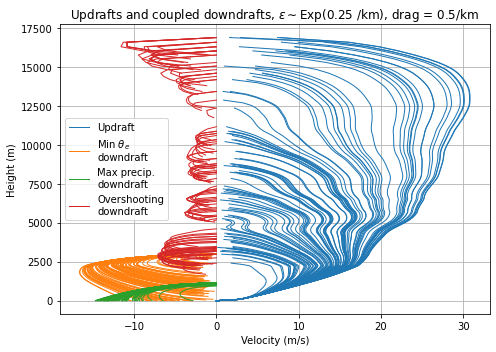

In [10]:
fig, ax = plt.subplots(figsize=(7,5))
lines = ax.plot(
    concatenate([[u.velocity] for u in updrafts]).T, height,
    'tab:blue', label='Updraft', linewidth=1)
plt.setp(lines[1:], label="_")
downdrafts1_filt = []
for d in downdrafts1:
    if d is not None:
        downdrafts1_filt.append(d)
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts1_filt]).T, height,
    'tab:orange', label='Min $\\theta_e$\ndowndraft', linewidth=1)
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts2]).T, height,
    'tab:green', label='Max precip.\ndowndraft', linewidth=1)
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts3]).T, height,
    'tab:red', label='Overshooting\ndowndraft', linewidth=1)
plt.setp(lines[1:], label="_")
ax.grid()
ax.legend()
ax.set(
    xlabel='Velocity (m/s)', ylabel='Height (m)',
    title='Updrafts and coupled downdrafts, '
          '$\\epsilon \\sim$Exp(0.25 /km), drag = 0.5/km')
fig.tight_layout()

## Stochastic parcel model
We now demonstrate an implementation of the stochastic parcel model presented by Romps and Kuang (2010). The rough outline of our implementation is as follows:

Entrainment is assumed to occur in discrete events as a Poisson process. To generate this process, a series of distances between successive entrainment events is drawn from the corresponding exponential distribution, and the distances summed one at a time to yield the locations of the events. Each location is then replaced by its closest sounding level.

The parcel is still modelled as a heterogeneous collection of components. Re-using the code from the original heterogeneous parcel model, we calculate and collect the properties of the original component of the parcel and the environmental components originating at the entrainment event levels.

The fractional mass entrained in an event is assumed to follow an exponential distribution; a value $m$ is drawn for each event. When an event occurs, the existing and incoming mass fractions are all scaled by a factor of $1/(1 + m)$.
Beginning with only the original component, we thus track the fractional mass of each component at each level.

Finally, we compute the average parcel properties, weighted by fractional mass. This leads to the buoyancy and velocity in the same manner as the original model.

In [3]:
# updraft parameters
i_init = pressure.size - 1
t_pert = 1.0*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init], temperature[i_init])
     - specific_humidity[i_init]
)
l_initial = 0*units.dimensionless
l_crit = 2.0e-3*units.dimensionless

# shared parameters
w_initial = 0*units.meter/units.second
lambda_ = 500*units.meter
sigma = 0.125*units.dimensionless
drag = 0.5/units.km

In [4]:
%%time
updrafts, downdrafts1, downdrafts2, downdrafts3 = stochastic.ensemble(
    i_init, t_pert, q_pert, l_initial, w_initial,
    lambda_, sigma, drag, l_crit, 100, basic=True)

Calculation 100 of 100    
CPU times: user 1min 38s, sys: 795 ms, total: 1min 39s
Wall time: 1min 44s


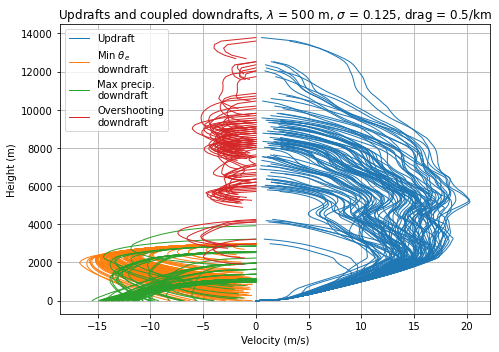

In [5]:
fig, ax = plt.subplots(figsize=(7,5))
lines = ax.plot(
    concatenate([[u.velocity] for u in updrafts]).T, height,
    'tab:blue', label='Updraft', linewidth=1)
plt.setp(lines[1:], label="_")
downdrafts1_filt = []
for d in downdrafts1:
    if d is not None:
        downdrafts1_filt.append(d)
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts1_filt]).T, height,
    'tab:orange', label='Min $\\theta_e$\ndowndraft', linewidth=1)
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts2]).T, height,
    'tab:green', label='Max precip.\ndowndraft', linewidth=1)
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts3]).T, height,
    'tab:red', label='Overshooting\ndowndraft', linewidth=1)
plt.setp(lines[1:], label="_")
ax.grid()
ax.legend()
ax.set(
    xlabel='Velocity (m/s)', ylabel='Height (m)',
    title='Updrafts and coupled downdrafts, '
          '$\\lambda$ = 500 m, $\\sigma$ = 0.125, drag = 0.5/km')
fig.tight_layout()

## Discussion
- The stochastic entrainment model produces much more variation in updraft precipitation and thus more variation in the precipitation-driven downdrafts originating at the level of maximum available precipitation.
- The strongest updrafts of the original model are absent in the stochastic model; velocities are more realistic in the latter.
- The stochastic entrainment model is twice as fast because it has fewer parcel components to consider.

## Thoughts
- In an ensemble of updrafts (downdrafts), individual members naturally terminate a while after they encounter negative (positive) buoyancy. Could this be used to model detrainment, rather than the assumption about the bulk detrainment rate being proportional to buoyancy?
- Downdraft initiation level could also be randomly chosen, e.g. normal distribution about the level of minimum $\theta_e$